In [3]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
sys.path.append('/home/massoale/Bureau/Stage_M2/stage_diags/diagnostics_pkg/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import scipy as sp
import io_utils as io

In [4]:

mode_file=np.load('/home/massoale/Bureau/Stage_M2/figures/Wave_sign/modes_jetdahu_6201.0.npy')
print(np.shape(mode_file))

(118, 2)


# Functions for finding Modes

In [5]:


def fft2d_RI(psi, k, l, Lx, nx, ny, time_tab):
    real_part_tab = np.zeros_like(time_tab, dtype=float)
    imag_part_tab = np.zeros_like(time_tab, dtype=float)
    dx = Lx / nx
    dy = Lx / ny

    kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi  
    

    kx_shifted = np.fft.fftshift(kx)
    ky_shifted = np.fft.fftshift(ky)
    
    Kx, Ky = np.meshgrid(kx_shifted, ky_shifted)
    

    for i, time_sel in enumerate(time_tab):
        
        psi_data = psi[time_sel, :, :]

        # 2D Fourier Transform
        fft_result = np.fft.fft2(psi_data) * 2 / (nx * ny)
        fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center

        # Find the index of the closest value to k in kx_shifted
        k_index = np.argmin(np.abs(k - kx_shifted))

        # Find the index of the closest value to l in ky_shifted
        l_index = np.argmin(np.abs(l - ky_shifted))

        # Extract the complex value at (k_index, l_index)
        complex_value = fft_shifted[l_index, k_index]

        # Get real and imaginary parts
        real_part_tab[i] = np.real(complex_value)
        imag_part_tab[i] = np.imag(complex_value)

    return real_part_tab, imag_part_tab


In [6]:

from joblib import Parallel, delayed

def fft2d_RI_vect(psi, Lx, nx, ny, time_tab):
    real_part_tab = np.zeros_like(psi, dtype=float)
    imag_part_tab = np.zeros_like(psi, dtype=float)
    dx = Lx / nx
    dy = Lx / ny

    kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi
    kx_shifted = np.fft.fftshift(kx)
    ky_shifted = np.fft.fftshift(ky)
    
    Kx, Ky = np.meshgrid(kx_shifted, ky_shifted)

    def process_time_step(time_sel):
        psi_data = psi[time_sel, :, :]

        # 2D Fourier Transform
        fft_result = np.fft.fft2(psi_data) * 2 / (nx * ny)
        fft_shifted = np.fft.fftshift(fft_result)

        # Extract the complex value at (k_index, l_index)
        complex_value = fft_shifted

        # Get real and imaginary parts
        return np.real(complex_value), np.imag(complex_value)

    # Process each time step in parallel
    results = Parallel(n_jobs=-1)(delayed(process_time_step)(time_sel) for time_sel in time_tab)

    # Unpack results
    for i, (real_part, imag_part) in enumerate(results):
        real_part_tab[i, :, :] = real_part
        imag_part_tab[i, :, :] = imag_part

    return real_part_tab, imag_part_tab, Kx, Ky


In [4]:


# def fft2d_RI_vect(psi, Lx, nx, ny, time_tab):
#     real_part_tab = np.zeros_like(psi, dtype=float)
#     imag_part_tab = np.zeros_like(psi, dtype=float)
#     dx = Lx / nx
#     dy = Lx / ny

#     kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
#     ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi  
    

#     # kx_reshaped=np.zeros_like(kx)
#     # kx_reshaped[0:len(kx)//2]=kx[len(kx)//2:]
#     # kx_reshaped[len(kx)//2:]=kx[0:len(kx)//2]

#     # ky_reshaped=np.zeros_like(ky)
#     # ky_reshaped[0:len(ky)//2]=ky[len(ky)//2:]
#     # ky_reshaped[len(ky)//2:]=ky[0:len(ky)//2]
#     kx_shifted = np.fft.fftshift(kx)
#     ky_shifted = np.fft.fftshift(ky)
    
#     Kx, Ky = np.meshgrid(kx_shifted, ky_shifted)
#     #Ky = np.flipud(Ky)

#     for i, time_sel in enumerate(time_tab):
        
#         psi_data = psi[time_sel, :, :]

#         # 2D Fourier Transform
#         fft_result = np.fft.fft2(psi_data) * 2 / (nx * ny)
#         fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center

#         # Extract the complex value at (k_index, l_index)
#         complex_value = fft_shifted

#         # Get real and imaginary parts
#         real_part_tab[i,:,:] = np.real(complex_value)
#         imag_part_tab[i,:,:] = np.imag(complex_value)

    

#     return real_part_tab, imag_part_tab , Kx, Ky


## Finding max amplitude mode function

In [7]:
#Function to find the mode with the maximum amplitude

def find_mode_max_amplitude(psi,Lx,nx,ny,time_tab):

    k_max=np.pi*2 / (Lx/(nx-1))
    k_min=2*np.pi/(Lx)

    k_step=(k_max-k_min)/(nx)

    #Making the arrays of wavenumbers we try
    k_range = np.arange(0, k_max, k_step)
    #l_range = np.arange(k_min, k_max, k_step)
    print("len k_range",len(k_range))
    print("k_min",k_min)
    print("k_max",k_max)
    amplitude_max=0
    k_ampmax=0
    l_ampmax=0
    #Going through all the wavenumbers
    for k in k_range:
        for l in k_range:
            real,im=fft2d_RI(psi,k,l,Lx,nx,ny,time_tab)
            amplitude=np.sqrt(real[0]**2+im[0]**2)#*(1/(np.pi*2))
            if (amplitude > amplitude_max):
                amplitude_max=amplitude
                k_ampmax=k
                l_ampmax=l
    return k_ampmax,l_ampmax,amplitude_max

## pulsation function 

In [8]:

def pulsation(real_part_tab, imag_part_tab, time_tab):
    """
    Computes the pulsation (omega = dθ/dt) of the signal.
    
    Parameters:
    real_part_tab (array): Array of the real part of the Fourier transform of psi.
    imag_part_tab (array): Array of the imaginary part of the Fourier transform of psi.
    time_tab (array): Time array.
    
    Returns:
    pulsation_observed (float): The observed pulsation.
    """
    
    # Calculate the complex signal psi
    amp=np.sqrt(real_part_tab**2+imag_part_tab**2)
    psi = (real_part_tab + 1j * imag_part_tab)/np.max(amp)
    
    # Calculate the conjugate of psi
    psi_conj = np.conjugate(psi)
    
    # Interpolated conjugate of psi
    psi_conj_interp = (psi_conj[1:] + psi_conj[:-1]) / 2
    
    # Norm and interpolated norm of psi
    psi_norm = np.sqrt(real_part_tab**2+imag_part_tab**2)
    psi_norm_interp = (psi_norm[1:] + psi_norm[:-1]) / 2
    
    # Time difference (assuming uniform spacing)
    dt = time_tab[1] - time_tab[0]
    
    # Compute pterm
    dreal_dt = (real_part_tab[1:] - real_part_tab[:-1]) / dt
    dimag_dt = (imag_part_tab[1:] - imag_part_tab[:-1]) / dt
    pterm = psi_conj_interp * (dreal_dt + 1j * dimag_dt)
    
    # Compute sterm
    psi_squared = real_part_tab**2 + imag_part_tab**2
    sterm = (psi_squared[1:] - psi_squared[:-1]) / dt
    
    # Calculate the pulsation
    pulsation_computed = 1 / (1j * psi_norm_interp) * (pterm - sterm)
   
    pulsation_observed = np.mean(pulsation_computed[2:-2])
    
    return pulsation_observed



In [9]:

def pulsation_vect(real_part_tab, imag_part_tab, time_tab):
    """
    Computes the pulsation (omega = dθ/dt) of the signal.
    
    Parameters:
    real_part_tab (array): Array of the real part of the Fourier transform of psi.
    imag_part_tab (array): Array of the imaginary part of the Fourier transform of psi.
    time_tab (array): Time array.
    
    Returns:
    pulsation_observed (float): The observed pulsation.
    """
    
    # Calculate the complex signal psi
    amp=np.sqrt(real_part_tab**2+imag_part_tab**2)
    psi = (real_part_tab + 1j * imag_part_tab)/np.max(amp)
    
    # Calculate the conjugate of psi
    psi_conj = np.conjugate(psi)
    
    # Interpolated conjugate of psi
    psi_conj_interp = (psi_conj[1:,:,:] + psi_conj[:-1,:,:]) / 2
    
    # Norm and interpolated norm of psi
    psi_norm = np.sqrt(real_part_tab**2+imag_part_tab**2)
    psi_norm_interp = (psi_norm[1:,:,:] + psi_norm[:-1,:,:]) / 2
    
    # Time difference (assuming uniform spacing)
    dt = time_tab[1] - time_tab[0]
    
    # Compute pterm
    dreal_dt = (real_part_tab[1:,:,:] - real_part_tab[:-1,:,:]) / dt
    dimag_dt = (imag_part_tab[1:,:,:] - imag_part_tab[:-1,:,:]) / dt
    pterm = psi_conj_interp * (dreal_dt + 1j * dimag_dt)
    
    # Compute sterm
    psi_squared = real_part_tab**2 + imag_part_tab**2
    sterm = (psi_squared[1:,:,:] - psi_squared[:-1,:,:]) / dt
    
    # Calculate the pulsation
    pulsation_computed = 1 / (1j * psi_norm_interp) * (pterm - sterm)
   
    pulsation_observed_mean = np.mean(pulsation_computed,axis=0)
    
    return pulsation_observed_mean



In [10]:
import numpy as np

def pulsation_vect(real_part_tab, imag_part_tab, time_tab):
    """
    Computes the pulsation (omega = dθ/dt) of the signal.
    
    Parameters:
    real_part_tab (array): Array of the real part of the Fourier transform of psi.
    imag_part_tab (array): Array of the imaginary part of the Fourier transform of psi.
    time_tab (array): Time array.
    
    Returns:
    pulsation_observed_mean (array): Mean observed pulsation over time.
    """

    # Time difference (assuming uniform spacing)
    dt = time_tab[1] - time_tab[0]
    
    # Prepare arrays for results
    pulsation_sum = np.zeros_like(real_part_tab[0], dtype=complex)
    count = len(time_tab) - 1

    for t in range(count):
        # Calculate the amplitude and complex signal psi for the current and next time step
        amp_t = np.sqrt(real_part_tab[t]**2 + imag_part_tab[t]**2)
        psi_t = (real_part_tab[t] + 1j * imag_part_tab[t]) / np.max(amp_t)
        
        amp_t1 = np.sqrt(real_part_tab[t + 1]**2 + imag_part_tab[t + 1]**2)
        psi_t1 = (real_part_tab[t + 1] + 1j * imag_part_tab[t + 1]) / np.max(amp_t1)

        # Calculate conjugate of psi
        psi_conj_interp = (np.conjugate(psi_t1) + np.conjugate(psi_t)) / 2
        
        # Calculate the interpolated norm of psi
        psi_norm_interp = (amp_t + amp_t1) / 2

        # Compute pterm
        dreal_dt = (real_part_tab[t + 1] - real_part_tab[t]) / dt
        dimag_dt = (imag_part_tab[t + 1] - imag_part_tab[t]) / dt
        pterm = psi_conj_interp * (dreal_dt + 1j * dimag_dt)

        # Compute sterm
        psi_squared_t = real_part_tab[t]**2 + imag_part_tab[t]**2
        psi_squared_t1 = real_part_tab[t + 1]**2 + imag_part_tab[t + 1]**2
        sterm = (psi_squared_t1 - psi_squared_t) / dt

        # Calculate the pulsation for this time step
        pulsation_t = 1 / (1j * psi_norm_interp) * (pterm - sterm)

        # Accumulate the pulsation values
        pulsation_sum += pulsation_t

    # Compute the mean over time
    pulsation_observed_mean = pulsation_sum / count

    return pulsation_observed_mean


In [11]:
#Finding the modes in the signal

def find_modes(psi_fft,freq_x,freq_y,seuil=0.5):
    # Get the amplitude of the Fourier components
    amplitude = np.abs(psi_fft)

    # Find the peak values (modes)
    # This part might need some fine-tuning based on your data
            
    threshold = np.max(amplitude) * seuil  # example threshold
    modes = np.where(amplitude > threshold)
    
    # Extract the corresponding (k, l) values
    l_modes = freq_x[modes[0]]
    k_modes = freq_y[modes[1]]

    return k_modes, l_modes


# Test Lennard Wave

In [12]:
#Dataset of Lennard :

#Reading the netcdf file
dataset=nc.Dataset('wave.nc')
print(dataset.variables.keys())


psi_lennard=dataset.variables['__xarray_dataarray_variable__'][:,:,:]
t=dataset.variables['time'][:]
x=dataset.variables['x'][:]
y=dataset.variables['y'][:]



nx=len(x)
ny=len(y)

k_max=np.pi*2/(x[1]-x[0])
k_min=2*np.pi/(x[-1]-x[0])

#print("kmax=",k_max,"kmin=",k_min)

dx=x[1]-x[0]
dy=y[1]-y[0]
Lx=len(x)*dx



dict_keys(['__xarray_dataarray_variable__', 'time', 'x', 'y'])


In [11]:
#Finding the mode with the maximum amplitude

time_tab=np.array([5])

k_found,l_found,amp_max=find_mode_max_amplitude(psi_lennard,Lx,nx,ny,time_tab)
print("k_max=",k_found,"l_max=",l_found," For an amplitude of",amp_max)


len k_range 102
k_min 1.5707963267948967e-06
k_max 0.00015550883635269476


k_max= 7.696902001294993e-06 l_max= 3.0787608005179972e-06  For an amplitude of 0.9999999999999999


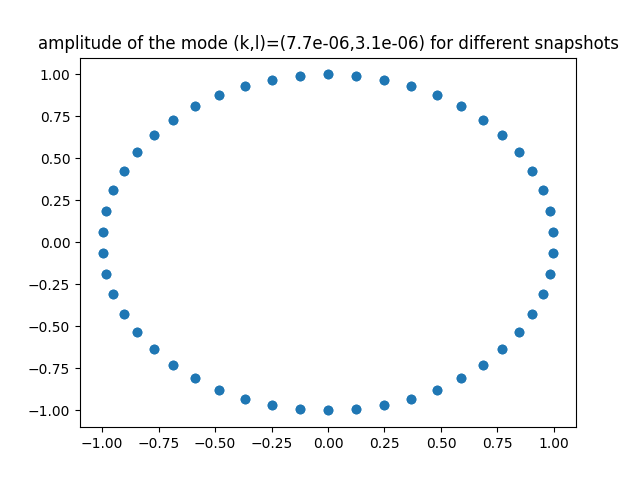

In [12]:
#Select time
time_sel_tab=np.arange(0,len(t),1)

k_test=k_found
l_test=l_found

real_part_tab,imag_part_tab=fft2d_RI(psi_lennard[:,:,:],k_test,l_test,Lx,nx,ny,time_sel_tab)

plt.figure()
plt.scatter(real_part_tab,imag_part_tab)
plt.title("amplitude of the mode (k,l)=("+str(f"{k_test:.2g}")+","+str(f"{l_test:.2g}")+") for different snapshots")
plt.show()

#print("the amplitude of the mode is ",np.mean(np.sqrt(real_part_tab**2+imag_part_tab**2))*(1/(np.pi*2)))

# fft_result = np.fft.fft2(psi_lennard[time_sel,:,:])

# fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center

# #Calculating Energy
# energy_spectrum = np.abs(fft_shifted) ** 2 * k_norm**2

# # Step 3: Plot the Spectrum

# plt.figure(figsize=(12, 6))
# plt.imshow(np.log(energy_spectrum +1e-5),  extent=(-np.max(kx), np.max(kx), -np.max(ky), np.max(ky)), cmap='hot', origin='lower',vmin=-10,vmax=10)


# plt.colorbar(label='Log Energy')
# plt.xlabel('k')
# plt.ylabel('l')
# plt.title('Instantaneous Energy Spectrum in (k, l) Space')
# plt.show()


k_true 7.957747154594768e-07 l_true 3.183098861837907e-07
(100,)


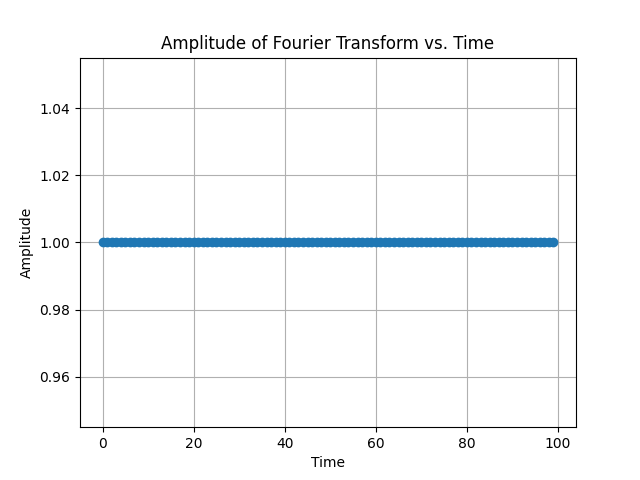

In [13]:
k_true=2.5/np.pi*10**(-6)
l_true=1/np.pi*10**(-6)
amplitude = np.sqrt(real_part_tab**2 + imag_part_tab**2)
print("k_true",k_true,"l_true",l_true)

print(time_sel_tab.shape)
plt.figure()
plt.plot(time_sel_tab, amplitude, marker='o')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Amplitude of Fourier Transform vs. Time')
plt.grid(True)
plt.show()

In [14]:
time_sel=2
kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi  
psi_fft = np.fft.fft2(psi_lennard[time_sel,:,:])
print(len(kx),len(ky))
#Finding the modes of the signal 
k_mode, l_mode = find_modes(psi_fft, kx,ky)

print(k_mode,l_mode)    

100 100
[ 7.85398163e-06 -7.85398163e-06] [ 3.14159265e-06 -3.14159265e-06]


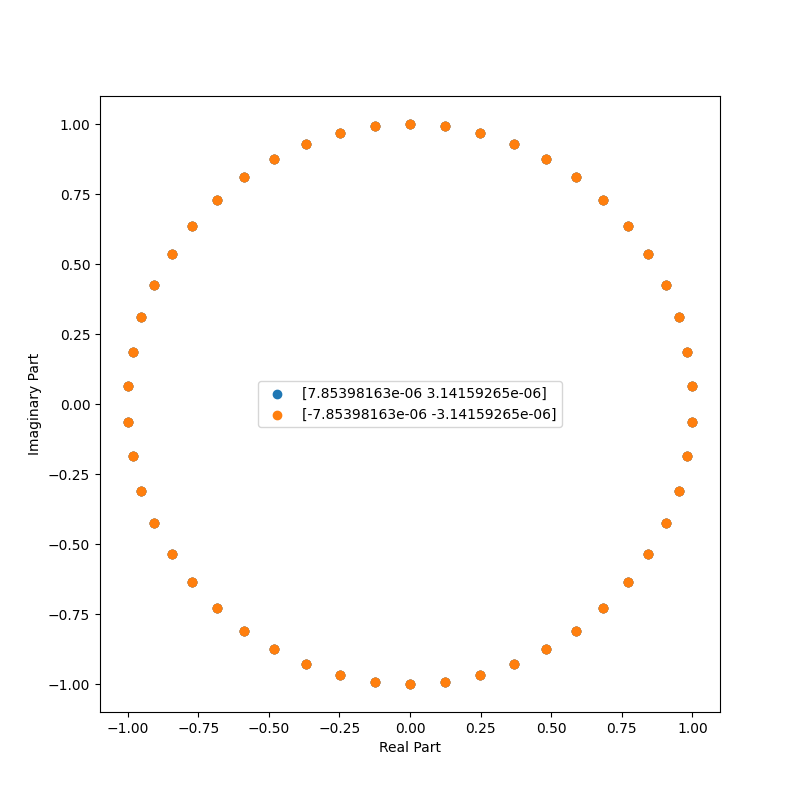

In [15]:
#This is a more appropriate code to  find the modes and not only the most energetic
kl_pairs = np.array(list(zip(k_mode, l_mode)))
time_sel_tab=np.arange(0,len(t),1)
epsilon = 1e-5
plt.figure(figsize=(8, 8))
for pair in kl_pairs:
    
    real_part_tab,imag_part_tab=fft2d_RI(psi_lennard[:,:,:],pair[0],pair[1],Lx,nx,ny,time_sel_tab)
    amp=np.sqrt(real_part_tab**2+imag_part_tab**2)
    
    #Check if the mode has a constant amplitude over time
    if np.abs(np.max(amp) - np.min(amp)) <= epsilon:
        #Then, we plot it
        plt.scatter(real_part_tab,imag_part_tab,label=str(pair))
        plt.legend()

plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
#plt.title("amplitude of the mode (k,l)=("+str(f"{k_test:.2g}")+","+str(f"{l_test:.2g}")+") for different snapshots")
plt.show()


/tmp/ipykernel_408794/3142787149.py:11: RuntimeWarning: invalid value encountered in divide
  puls_rossby_mat = np.abs(-(beta*Kx/(Kx**2+Ky**2)))


(100, 100, 100) (100, 100, 100)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2, 2)
[45 55]


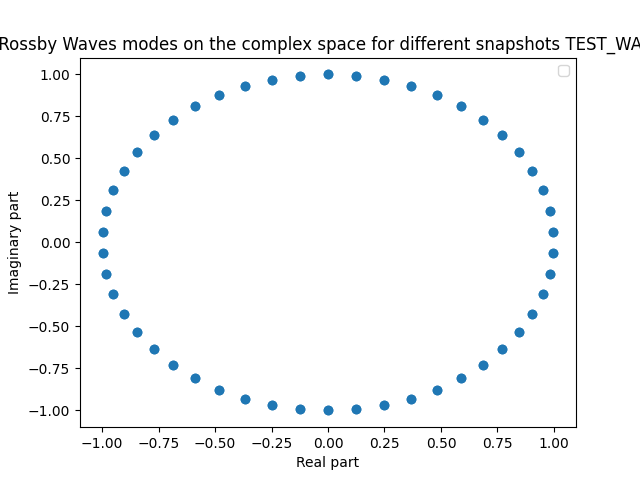

In [16]:
#On cherche en mode vectorisé

#Criterium to select the rossby waves
epsilon=0.1
beta=2e-11


real_part_tab,imag_part_tab,Kx,Ky = fft2d_RI_vect(psi_lennard[:,:,:],Lx,nx,ny,time_sel_tab)

amp = np.sqrt(real_part_tab**2+imag_part_tab**2)
puls_rossby_mat = np.abs(-(beta*Kx/(Kx**2+Ky**2)))
print(np.shape(real_part_tab),np.shape(imag_part_tab))
#Création d'une matrice qui contient les période  des Onde de Rossby associés à chaques modes:
mat_rossby_time = np.zeros_like(amp)
mat_rossby_time[0,:,:] = puls_rossby_mat/(np.pi*2)

#Expanding it for every time
mat_rossby_time = np.tile(mat_rossby_time[0, :, :], (len(time_sel_tab), 1, 1))

puls_complex_mat = pulsation_vect(real_part_tab,imag_part_tab,t)

#Finding the modes that fulfill the two conditions (one on the mean pulsation and one on the variation of amplitude of the wave)

condition1 = np.abs((np.abs(np.real(puls_complex_mat))-puls_rossby_mat)/puls_rossby_mat) < epsilon

inv_amp_time =  (amp[1:,:,:]**2-amp[:-1,:,:]**2)/(t[1]-t[0]) / ( (amp[1:,:,:]+amp[:-1,:,:])/2 )**2 
mean_inv_amp_time = np.abs(np.mean(inv_amp_time)) #Petite modif par rapport à avant
condition2 = mean_inv_amp_time < np.abs(puls_rossby_mat/np.pi*2)

indices=np.argwhere(condition1 & condition2)
print(np.shape(indices))
print(indices[:,1])
plt.figure()
plt.scatter(real_part_tab[time_sel_tab,indices[0,0],indices[0,1]],imag_part_tab[time_sel_tab,indices[0,0],indices[0,1]])

plt.title(" Rossby Waves modes on the complex space for different snapshots TEST_WAVE")
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
#plt.text(0.1, 0.9, "simu"+str(simu_name), horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes)

plt.legend()
#plt.savefig('figures/Wave_sign/Rossby_waves_vect'+str(simu_name)+'.png')
plt.show()


## Finding the corresponding beta

In [17]:
#Determining the pulsation of the signal:
time_sel_tab=np.arange(0,len(t),1)
print(t[1]-t[0])
real_part_tab,imag_part_tab=fft2d_RI(psi_lennard[:,:,:],pair[0],pair[1],Lx,nx,ny,time_sel_tab)
real_part_tab_lennard=real_part_tab
imag_part_tab_lennard=imag_part_tab

pulsation_observed=np.mean(np.real(pulsation(real_part_tab,imag_part_tab,t)))
print(pulsation_observed)

57243.70552631826
-2.189467512837394e-06


In [18]:
#Finding beta
beta=(pair[0]**2+pair[1]**2) * pulsation_observed/pair[0]
print("beta=",beta)
beta_true=2e-11
print("Beta error",np.abs(beta-beta_true)/beta_true*100,"%")

beta= 1.9947403655450065e-11
Beta error 0.2629817227496672 %


# Simulation field



la simulation chargée est: dahu_317
depuis: dahu
KeysView(Frozen({'time': <xarray.IndexVariable 'time' (time: 341)> Size: 1kB
array([   0.,   10.,   20., ..., 3380., 3390., 3400.], dtype=float32), 'y': <xarray.IndexVariable 'y' (y: 1025)> Size: 4kB
array([0.000000e+00, 2.454369e-01, 4.908738e-01, ..., 2.508365e+02,
       2.510820e+02, 2.513274e+02], dtype=float32), 'x': <xarray.IndexVariable 'x' (x: 1025)> Size: 4kB
array([0.000000e+00, 2.454369e-01, 4.908738e-01, ..., 2.508365e+02,
       2.510820e+02, 2.513274e+02], dtype=float32), 'level': <xarray.IndexVariable 'level' (level: 1)> Size: 4B
array([0.], dtype=float32), 'psi': <xarray.Variable (time: 341, level: 1, y: 1025, x: 1025)> Size: 1GB
dask.array<open_dataset-psi, shape=(341, 1, 1025, 1025), dtype=float32, chunksize=(10, 1, 1025, 1025), chunktype=numpy.ndarray>, 'q': <xarray.Variable (time: 341, level: 1, y: 1025, x: 1025)> Size: 1GB
dask.array<open_dataset-q, shape=(341, 1, 1025, 1025), dtype=float32, chunksize=(10, 1, 1025, 

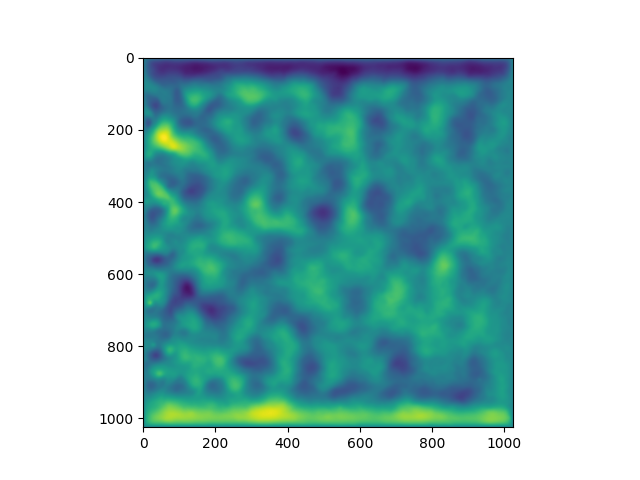

In [13]:
import dask.array as da
import xarray as xr


# Number of simulation
n = 317

# Choose between 'local' or 'dahu'
where = 'dahu'

# Reading the netcdf file
if where == 'local':
    if n < 10:
        simu_name = 'outdir_000' + str(n)
    elif n < 100 and n >= 10:
        simu_name = 'outdir_00' + str(n)
    Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
elif where == 'dahu':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'
else:
    print('Error: where not recognized')
    sys.exit()

print('la simulation chargée est: ' + simu_name)
print("depuis: " + where)

filenames = ['/vars.nc']

# Open the dataset using xarray
dataset = xr.open_dataset(Path + filenames[0], chunks={'time': 10})

print(dataset.variables.keys())

# Load variables in chunks
t = dataset['time'].isel(time=slice(0, 400)).data
x = dataset['x'].data
y = dataset['y'].data
psi = dataset['psi'].isel(time=slice(0, 400), level=0).data
q = dataset['q'].isel(time=slice(0, 400), level=0).data

# Lecture des paramètres :
param = io.read_params(Path)
print(param)
f0 = param['f0']
beta = param['beta']
hEkb = param['hEkb']
dh = param['dh'][0]
Lx = param['Lx']
nx = int(param['NX'])
ny = int(param['NY'])
k_f = param['k_f']
sigma_f = param['sigma_f']
bc_fac = param['bc_fac']
nu_hyper = param['nu_hyper']
n_hyper = param['n_hyper']
dt_out = param['dt_out']

plt.figure()
plt.imshow(psi[-2, :, :])
print(np.shape(t))


In [14]:
502//(np.pi*2)

79.0

# here


In [15]:
#Computing the dtout timesteps requiered to see the evolution of the signal
r=hEkb
epsilon=sigma_f**2

Tmax=np.pi*2*k_f/beta
Tmin=1/(1/(beta**0.5/(epsilon/r)**(1/4)))*1/beta
print(Tmin,Tmax)
print("put the dtout at least to ",Tmin/5,"run the simulation for ",0.22214*5/0.05,"time units")

0.25 6.283185307179586
put the dtout at least to  0.05 run the simulation for  22.214 time units


In [5]:
time_tab=np.array([10])

nx=len(x)
ny=len(y)

k_max=np.pi*2/(x[1]-x[0])
k_min=2*np.pi/(x[-1]-x[0])

print("kmax=",k_max,"kmin=",k_min)

dx=x[1]-x[0]
dy=y[1]-y[0]
Lx=nx*dx
print("psi max, psi mean",np.max(psi),np.mean(psi))
print(Lx,nx,ny,dx,dy)
#k_max,l_max,amp_max=find_mode_max_amplitude(psi,Lx,nx,ny,time_tab)

kmax= 25.600000453300726 kmin= 0.012506106356367135
psi max, psi mean dask.array<max-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray> dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
502.6548156738281 2048 2048 0.24543692 0.24543692


## Finding waves

In [6]:
#Finding the modes out of the noise which could be candidates for Rossby waves

#List of the indices for the time of each snapshots
time_sel_tab=np.arange(0,len(t),4)
print("shape of the time sel:",np.shape(time_sel_tab))
#selecting a time snapshot for the fourier transform
time_sel=2


kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi  
psi_fft = np.fft.fft2(psi[time_sel,:,:])*2/(nx*ny)


#k_mode,l_mode=find_modes(psi_fft,kx,ky,0.4)
#print("modes found:",len(k_mode))
#kl_pairs = np.array(list(zip(k_mode, l_mode)))

shape of the time sel: (100,)


In [7]:
# import dask.array as da
# import dask
# import xarray as xr
# import numpy as np
# import matplotlib.pyplot as plt
# from dask.diagnostics import ProgressBar

# def fft2d_RI_vect_optimized(psi, Lx, nx, ny, time_tab):
#     real_part_tab = da.zeros((len(time_tab), ny, nx), dtype=float)
#     imag_part_tab = da.zeros((len(time_tab), ny, nx), dtype=float)
#     dx = Lx / nx
#     dy = Lx / ny

#     kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
#     ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi
#     kx_shifted = np.fft.fftshift(kx)
#     ky_shifted = np.fft.fftshift(ky)
#     Kx, Ky = np.meshgrid(kx_shifted, ky_shifted)

#     def compute_fft(time_sel):
#         psi_data = psi[time_sel, :, :]
#         fft_result = da.fft.fft2(psi_data) * 2 / (nx * ny)
#         fft_shifted = da.fft.fftshift(fft_result)
#         real_part = da.real(fft_shifted)
#         imag_part = da.imag(fft_shifted)
#         return real_part, imag_part

#     delayed_results = [dask.delayed(compute_fft)(time_sel) for time_sel in time_tab]
#     computed = da.compute(*delayed_results)

#     for i, (real_part, imag_part) in enumerate(computed):
#         real_part_tab[i, :, :] = real_part
#         imag_part_tab[i, :, :] = imag_part

#     return real_part_tab, imag_part_tab, Kx, Ky

# def pulsation_vect_optimized(real_part_tab, imag_part_tab, t, time_tab):
#     dt = t[time_tab[1]] - t[time_tab[0]]
#     count = real_part_tab.shape[0] - 1

#     pulsation_sum = da.zeros_like(real_part_tab[0], dtype=complex)
#     pulsation_var = da.zeros_like(real_part_tab[0], dtype=complex)
#     for t in range(count):
#         real_t, imag_t = real_part_tab[t], imag_part_tab[t]
#         real_t1, imag_t1 = real_part_tab[t + 1], imag_part_tab[t + 1]
        
#         amp_t = da.sqrt(real_t**2 + imag_t**2)
#         psi_t = (real_t + 1j * imag_t) / da.max(amp_t)
        
#         amp_t1 = da.sqrt(real_t1**2 + imag_t1**2)
#         psi_t1 = (real_t1 + 1j * imag_t1) / da.max(amp_t1)

#         psi_conj_interp = (da.conj(psi_t1) + da.conj(psi_t)) / 2
#         psi_norm_interp = (amp_t + amp_t1) / 2

#         dreal_dt = (real_t1 - real_t) / dt
#         dimag_dt = (imag_t1 - imag_t) / dt
#         pterm = psi_conj_interp * (dreal_dt + 1j * dimag_dt)

#         psi_squared_t = real_t**2 + imag_t**2
#         psi_squared_t1 = real_t1**2 + imag_t1**2
#         sterm = (psi_squared_t1 - psi_squared_t) / dt

#         pulsation_t = 1 / (1j * psi_norm_interp) * (pterm - sterm)
#         pulsation_sum += da.abs(pulsation_t)
#         pulsation_var += pulsation_t**2

#     pulsation_observed_mean = pulsation_sum / count
#     pulsation_var = pulsation_var / count 
#     return pulsation_observed_mean, pulsation_var

# # Parameters
# epsilon = 0.2

# # List of the indices for the time of each snapshot
# time_sel_tab = np.arange(0, len(t), 4)
# print("Selected time indices:", time_sel_tab)

# # FFT Calculation
# real_part_tab, imag_part_tab, Kx, Ky = fft2d_RI_vect_optimized(psi, Lx, nx, ny, time_sel_tab)
# print("Real part shape:", np.shape(real_part_tab))

# # Calculate pulsation of Rossby waves
# puls_rossby_mat = da.abs(-(beta * Kx / (Kx**2 + Ky**2)))

# # Calculate pulsation
# puls_complex_mat, puls_var = pulsation_vect_optimized(real_part_tab, imag_part_tab, t, time_sel_tab)
# std = da.sqrt(puls_var - puls_complex_mat**2)

# # Conditions for selecting modes
# inv_amp_time = da.zeros_like(real_part_tab[1:, :, :])

# dt = t[time_sel_tab[1]] - t[time_sel_tab[0]]
# for i in range(1, len(real_part_tab)):
#     amp_i = da.sqrt(real_part_tab[i]**2 + imag_part_tab[i]**2)
#     amp_im1 = da.sqrt(real_part_tab[i-1]**2 + imag_part_tab[i-1]**2)
#     inv_amp_time[i-1, :, :] = (amp_i**2 - amp_im1**2) / dt / ((amp_i + amp_im1) / 2)**2

# mean_inv_amp_time = da.abs(da.mean(inv_amp_time, axis=0))
# condition1 = da.std(da.abs(da.sqrt(real_part_tab**2 + imag_part_tab**2)), axis=0) / da.mean(da.abs(da.sqrt(real_part_tab**2 + imag_part_tab**2)), axis=0) < epsilon
# condition2 = std / da.abs(puls_complex_mat) < 0.1
# indices = da.argwhere(condition1 & condition2)

# # Compute final results
# with ProgressBar():
#     indices = indices.compute()

# print("Indices shape:", np.shape(indices))


In [8]:
#################################################################Aide de Chat GPT########################################################################""


def fft2d_RI_vect_optimized(psi, Lx, nx, ny, time_tab):
    real_part_tab = np.zeros((len(time_tab), ny, nx), dtype=float)
    imag_part_tab = np.zeros((len(time_tab), ny, nx), dtype=float)
    dx = Lx / nx
    dy = Lx / ny

    kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi
    kx_shifted = np.fft.fftshift(kx)
    ky_shifted = np.fft.fftshift(ky)
    Kx, Ky = np.meshgrid(kx_shifted, ky_shifted)

    for i, time_sel in enumerate(time_tab):
        psi_data = psi[time_sel, :, :]
        fft_result = np.fft.fft2(psi_data) * 2 / (nx * ny)
        fft_shifted = np.fft.fftshift(fft_result)
        real_part_tab[i, :, :] = np.real(fft_shifted)
        imag_part_tab[i, :, :] = np.imag(fft_shifted)

    return real_part_tab, imag_part_tab, Kx, Ky



def pulsation_vect_optimized(real_part_tab, imag_part_tab, t,time_tab):
    dt = t[time_tab[1]] - t[time_tab[0]]
    count = real_part_tab.shape[0] - 1

    pulsation_sum = np.zeros_like(real_part_tab[0], dtype=complex)
    pulsation_var = np.zeros_like(real_part_tab[0], dtype=complex)
    for t in range(count):
        real_t, imag_t = real_part_tab[t], imag_part_tab[t]
        real_t1, imag_t1 = real_part_tab[t + 1], imag_part_tab[t + 1]
        
        amp_t = np.sqrt(real_t**2 + imag_t**2)
        psi_t = (real_t + 1j * imag_t) / np.max(amp_t)
        
        amp_t1 = np.sqrt(real_t1**2 + imag_t1**2)
        psi_t1 = (real_t1 + 1j * imag_t1) / np.max(amp_t1)

        psi_conj_interp = (np.conjugate(psi_t1) + np.conjugate(psi_t)) / 2
        psi_norm_interp = (amp_t + amp_t1) / 2

        dreal_dt = (real_t1 - real_t) / dt
        dimag_dt = (imag_t1 - imag_t) / dt
        pterm = psi_conj_interp * (dreal_dt + 1j * dimag_dt)

        psi_squared_t = real_t**2 + imag_t**2
        psi_squared_t1 = real_t1**2 + imag_t1**2
        sterm = (psi_squared_t1 - psi_squared_t) / dt

        pulsation_t = 1 / (1j * psi_norm_interp) * (pterm - sterm)
        pulsation_sum += np.abs(pulsation_t)
        pulsation_var += pulsation_t**2

    pulsation_observed_mean = pulsation_sum / count
    pulsation_var = pulsation_var / count 
    return pulsation_observed_mean, pulsation_var



In [9]:
#Criterium:
epsilon=0.3

#for epsilon in np.arange(0.1, 0.8, 0.1):

# List of the indices for the time of each snapshots
time_sel_tab = np.arange(0, len(t), 4)
print("Selected time indices:", time_sel_tab)

# FFT Calculation

real_part_tab, imag_part_tab, Kx, Ky = fft2d_RI_vect_optimized(psi, Lx, nx, ny, time_sel_tab)
print("Real part shape:", np.shape(real_part_tab))

# Calculate pulsation of Rossby waves
puls_rossby_mat = np.abs(-(beta * Kx / (Kx**2 + Ky**2)))

# # Create matrix for Rossby wave periods
# mat_rossby_time = np.zeros_like(real_part_tab)
# mat_rossby_time[0, :, :] = puls_rossby_mat / (np.pi * 2)
# mat_rossby_time = np.tile(mat_rossby_time[0, :, :], (len(time_sel_tab), 1, 1))

# Calculate pulsation
puls_complex_mat,puls_var = pulsation_vect_optimized(real_part_tab, imag_part_tab, t, time_sel_tab)
std = np.sqrt(puls_var - puls_complex_mat**2)
# Conditions for selecting modes
#condition1 = 1#np.abs((np.abs(np.real(puls_complex_mat)) - puls_rossby_mat) / puls_rossby_mat) < epsilon

# Calculate inverse amplitude over time to avoid storing large arrays"
inv_amp_time = np.zeros_like(real_part_tab[1:, :, :])

dt = t[time_sel_tab[1]]-t[time_sel_tab[0]]
for i in range(1, len(real_part_tab)):
    amp_i = np.sqrt(real_part_tab[i]**2 + imag_part_tab[i]**2)
    amp_im1 = np.sqrt(real_part_tab[i-1]**2 + imag_part_tab[i-1]**2)
    inv_amp_time[i-1, :, :] = (amp_i**2 - amp_im1**2) / dt / ((amp_i + amp_im1) / 2)**2

mean_inv_amp_time = np.abs( np.mean(inv_amp_time, axis=0) )
condition1 = np.std(np.abs(np.sqrt(real_part_tab**2 + imag_part_tab**2)) , axis=0)\
    /np.mean(np.abs(np.sqrt(real_part_tab**2 + imag_part_tab**2) ), axis=0)<epsilon#0.3#mean_inv_amp_time < 4*np.abs(puls_complex_mat / (np.pi * 2))
condition2 = std/np.abs(puls_complex_mat) < 0.1
indices = np.argwhere(condition1 & condition2)
print("Indices shape:", np.shape(indices))
#print(indices)


Selected time indices: [  0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68
  72  76  80  84  88  92  96 100 104 108 112 116 120 124 128 132 136 140
 144 148 152 156 160 164 168 172 176 180 184 188 192 196 200 204 208 212
 216 220 224 228 232 236 240 244 248 252 256 260 264 268 272 276 280 284
 288 292 296 300 304 308 312 316 320 324 328 332 336 340 344 348 352 356
 360 364 368 372 376 380 384 388 392 396]
Real part shape: (100, 2048, 2048)


/tmp/ipykernel_608970/2238569582.py:16: RuntimeWarning: invalid value encountered in divide
  puls_rossby_mat = np.abs(-(beta * Kx / (Kx**2 + Ky**2)))


Indices shape: (226, 2)


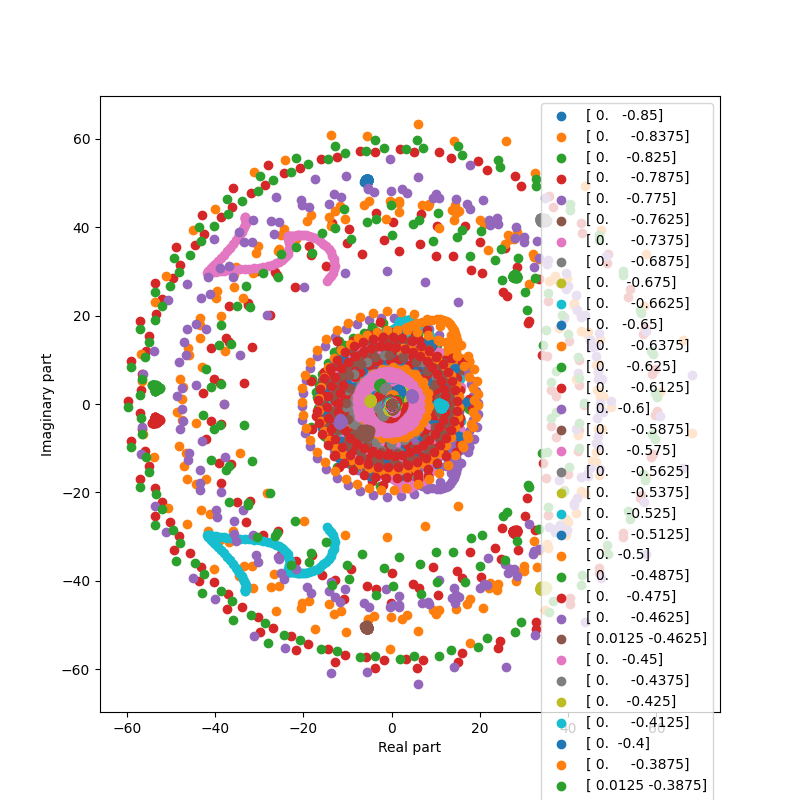

In [10]:

plt.figure(figsize=(8,8))
for n in range(0,len(indices)):
    mode=np.round([ Ky[indices[n,1],0],Kx[0,indices[n,0]] ],4)
    plt.scatter(real_part_tab[:, indices[n, 0], indices[n, 1]], 
                imag_part_tab[:, indices[n, 0], indices[n, 1]], label=str(mode))

#plt.title("Rossby Waves modes on the complex space for different snapshots")
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.legend()
plt.savefig('figures/Wave_sign/Rossby_waves_vect_simu_condiV3'+simu_name+str(epsilon)+'.png')
plt.show()

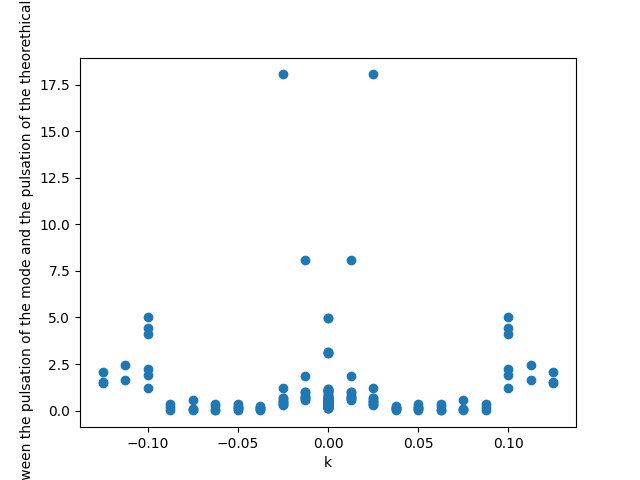

In [11]:
puls_complex_mat_ind=np.zeros(np.shape(indices[:,0]))
puls_rossby_mat_ind=np.zeros(np.shape(indices[:,0]))
k_ind=np.zeros(np.shape(indices[:,0])) 
for n in range(0,len(indices)):
    #print(np.shape(real_part_tab))
    puls_rossby_mat_ind[n] = np.abs(-(beta * Kx[indices[n,0],indices[n,1]] / (Kx[indices[n,0],indices[n,1]]**2 + Ky[indices[n,0],indices[n,1]]**2) ))
    puls_complex_mat_ind[n],_ = np.abs(pulsation_vect_optimized(real_part_tab[:,indices[n,0],indices[n,1]], imag_part_tab[:,indices[n,0],indices[n,1]], t, time_sel_tab))
    k_ind[n]=Kx[indices[n,0],indices[n,1]]
    #print(n,"/",len(indices))
plt.figure()
plt.scatter(k_ind,np.abs(puls_complex_mat_ind-puls_rossby_mat_ind))
#plt.loglog()
plt.xlabel('k')
plt.ylabel('Difference between the pulsation of the mode and the pulsation of the theorethical Rossby wave')
plt.savefig('figures/Wave_sign/Shifted_pulsation'+simu_name+str(epsilon)+'.png')
#plt.plot(indices[:,0])
#plt.imshow(Kx)
plt.show()

In [18]:
#Finding the modes for the jets
def find_jet(indices,Kx,Ky):
    mode_jet=[]
    i=0
    for n in range(0,len(indices)):
        mode=np.round([ Ky[indices[n,1],0],Kx[0,indices[n,0]] ],4)
        print("here",mode)
        if mode[0]==0:
            i+=1
            mode_jet.append(mode)
    mode_jet=np.array(mode_jet)
    
    #save the modes in a file
    np.save('figures/Wave_sign/modes_jet'+simu_name+'.npy',mode_jet)
    return mode_jet

def find_jet_light(indices,Kx,Ky):
    #Finding the modes for the jets but it takes only the poistives modes and one over two
    mode_jet=[]
    i=0
    for n in range(0,len(indices)//2):
        mode=np.round([ Ky[indices[2*n,1],0],Kx[0,indices[2*n,0]] ],4)
        
        if mode[0]==0 and mode[1]>=0:
            i+=1
            mode_jet.append(mode)
    mode_jet=np.array(mode_jet)
    #save the modes in a file
    np.save('figures/Wave_sign/modes_jet_light'+simu_name+'.npy',mode_jet)
    return mode_jet

mode_jet=find_jet(indices,Kx,Ky)
mode_jet_light=find_jet_light(indices,Kx,Ky)
print(np.shape(mode_jet),np.shape(mode_jet_light))

#The first index where the mode is non null 
idx=np.where(Kx[indices[:,0],indices[:,1]]!=0)[0][0]

print("The mode is",Kx[indices[idx,0],indices[idx,1]],Ky[indices[idx,0],indices[idx,1]])
print("check of the mode",Kx[ 993,1025],Ky[ 993,1025])

print(mode)

here [ 0.   -0.85]
here [ 0.     -0.8375]
here [ 0.    -0.825]
here [ 0.     -0.7875]
here [ 0.    -0.775]
here [ 0.     -0.7625]
here [ 0.     -0.7375]
here [ 0.     -0.6875]
here [ 0.    -0.675]
here [ 0.     -0.6625]
here [ 0.   -0.65]
here [ 0.     -0.6375]
here [ 0.    -0.625]
here [ 0.     -0.6125]
here [ 0.  -0.6]
here [ 0.     -0.5875]
here [ 0.    -0.575]
here [ 0.     -0.5625]
here [ 0.     -0.5375]
here [ 0.    -0.525]
here [ 0.     -0.5125]
here [ 0.  -0.5]
here [ 0.     -0.4875]
here [ 0.    -0.475]
here [ 0.     -0.4625]
here [ 0.0125 -0.4625]
here [ 0.   -0.45]
here [ 0.     -0.4375]
here [ 0.    -0.425]
here [ 0.     -0.4125]
here [ 0.  -0.4]
here [ 0.     -0.3875]
here [ 0.0125 -0.3875]
here [ 0.    -0.375]
here [ 0.     -0.3625]
here [ 0.   -0.35]
here [ 0.     -0.3375]
here [ 0.    -0.325]
here [ 0.     -0.3125]
here [ 0.     -0.2875]
here [-0.0125 -0.275 ]
here [ 0.    -0.275]
here [ 0.05  -0.275]
here [ 0.     -0.2625]
here [-0.025 -0.25 ]
here [ 0.   -0.25]
here [

: 

In [13]:
# #On cherche en mode vectorisé

# #Criterium to select the rossby waves
# epsilon=0.1

# ####real_part_tab,imag_part_tab,Kx,Ky = fft2d_RI_vect(psi[:,:,:],Lx,nx,ny,time_sel_tab)

# amp = np.sqrt(real_part_tab**2+imag_part_tab**2)
# puls_rossby_mat = np.abs(-(beta*Kx/(Kx**2+Ky**2)))

# #Création d'une matrice qui contient les période  des Onde de Rossby associés à chaques modes:
# mat_rossby_time = np.zeros_like(amp)
# mat_rossby_time[0,:,:] = puls_rossby_mat/(np.pi*2)

# #Expanding it for every time
# mat_rossby_time = np.tile(mat_rossby_time[0, :, :], (len(time_sel_tab), 1, 1))

# puls_complex_mat = pulsation_vect(real_part_tab,imag_part_tab,t)

# #Finding the modes that fulfill the two conditions (one on the mean pulsation and one on the variation of amplitude of the wave)

# condition1 = np.abs((np.abs(np.real(puls_complex_mat))-puls_rossby_mat)/puls_rossby_mat) < epsilon

# inv_amp_time = (amp[1:,:,:]**2-amp[:-1,:,:]**2)/(t[1]-t[0]) / ( (amp[1:,:,:]+amp[:-1,:,:])/2 )**2 
# mean_inv_amp_time = np.abs(np.mean(inv_amp_time)) #Petite modif par rapport à avant
# condition2 = mean_inv_amp_time < np.abs(puls_rossby_mat/np.pi*2)

# indices=np.argwhere(condition1 & condition2)
# print(np.shape(indices))
# plt.figure()
# plt.scatter(real_part_tab[time_sel_tab,indices[0,0],indices[0,1]],imag_part_tab[time_sel_tab,indices[0,0],indices[0,1]])

# plt.title(" Rossby Waves modes on the complex space for different snapshots of simu"+str(simu_name))
# plt.xlabel('Real part')
# plt.ylabel('Imaginary part')
# #plt.text(0.1, 0.9, "simu"+str(simu_name), horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes)

# plt.legend()
# plt.savefig('figures/Wave_sign/Rossby_waves_vect'+str(simu_name)+'.png')
# plt.show()


## Finding the wave regions

In [14]:
# time_tab=np.arange(0,len(t),1)
# time_tab = time_tab.astype(int)

# print(len(time_tab),np.shape(psi))

# for pair in kl_pairs:
#     if pair[0]==0:
#         continue
#     print(pair)
#     real_part_tab,imag_part_tab=fft2d_RI(psi[:,:,:],pair[0],pair[1],Lx,nx,ny,time_tab)
#     puls_complex=pulsation(real_part_tab[:],imag_part_tab[:],t) 
#     pulsation_observed=np.pi*2/5800 #np.real(puls_complex)
#     print("puls",puls_complex)
#     #Finding beta
#     k=pair[0]
#     l=pair[1]
#     beta_test=(k**2+l**2)*np.real(puls_complex)/k

#     print("beta=",beta)
#     beta_true=1
#     puls_true=np.abs(-beta_true*pair[0]/(pair[0]**2+pair[1]**2))
#     #print("Beta error",np.abs(beta-beta_true)/beta_true*100,"%")
#     print("Puls error",(np.abs(np.real(puls_complex))-puls_true)/puls_true)

# print("puls calc",np.pi*2/3e6)


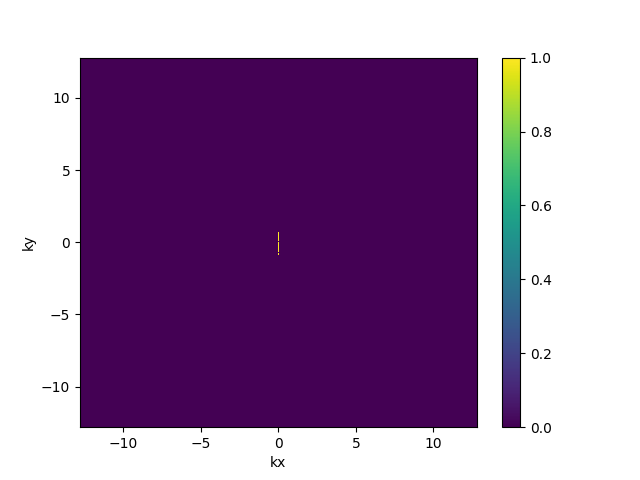

In [15]:
#Plotting a binary map of the region where the Rossby waves are present
#epsilon=sigma_f**2
#r=  hEkb
#k_rhines=beta**0.5/(epsilon/r)**(1/4)
#print(k_rhines,k_f)
#print("k rhines index",k_rhines*Lx/(np.pi*2))
kx_computed = np.arange(0,k_f,kx[1]-kx[0])
ky_computed = np.arange(0,k_f,ky[1]-ky[0])
binary_map = np.zeros((2048,2048))#((l*en(kx_computed), len(ky_computed)))

plt.figure()

for i in range(0,len(indices)):
    #k_index = #np.argmin(np.abs(pair[0] - kx_computed))
    #l_index = np.argmin(np.abs(pair[1] - ky_computed))
    
    mode=np.round([ Ky[indices[i,1],0],Kx[0,indices[i,0]] ],4)
        
    if mode[0]==0 :
        
        binary_map[indices[i,0], indices[i,1]] = 1

#lt.pcolormesh(KX,KY,binary_map, cmap='binary')
plt.pcolormesh(Kx,Ky,binary_map) 
plt.colorbar()
#plt.text(k_rhines, 0, 'kr', fontsize=12, ha='center')
plt.xlabel("kx")
plt.ylabel("ky")
plt.show()




In [16]:
#Finding teh modes where k=0
idx=np.where(Kx[indices[:,0],indices[:,1]]==0)
print(idx)
print(np.shape(Kx[indices[:,0],indices[:,1]]))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  26,
        27,  28,  29,  30,  31,  33,  34,  35,  36,  37,  38,  39,  41,
        43,  45,  47,  48,  49,  50,  51,  56,  57,  60,  63,  72,  79,
        84,  90,  96,  99, 104, 106, 109, 116, 119, 121, 126, 129, 135,
       141, 146, 153, 162, 165, 168, 169, 174, 175, 176, 177, 178, 180,
       182, 184, 186, 187, 188, 189, 190, 191, 192, 194, 195, 196, 197,
       198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225]),)
(226,)


50 50
waveinv temp 0.025543423225605145
puls rossby 0.03627803342243118
non wave inv temp 0.034414667071380446
puls rossby 0.0359670068625669


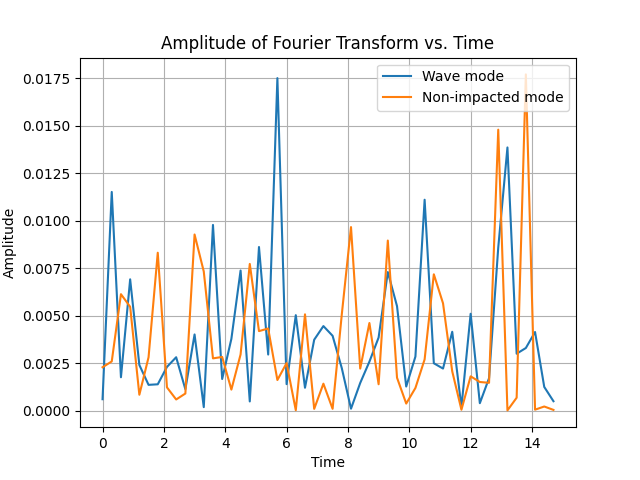

In [ ]:

ind_k_wave = 1074 #x axis
ind_l_wave = 1011 #y axis

ind_k_nimp = 1075#964
ind_l_nimp = 1011
# Plotting the amplitude evolution of two modes

mode_wave = real_part_tab[:,ind_l_wave,ind_k_wave]**2 + imag_part_tab[:,ind_l_wave,ind_k_wave]**2
mode_nimp = real_part_tab[:,ind_l_nimp,ind_k_nimp]**2 + imag_part_tab[:,ind_l_nimp,ind_k_nimp]**2
print(len(t[time_sel_tab]),len(mode_wave))

amp_i_wave = np.sqrt(real_part_tab[1:,ind_l_wave,ind_k_wave]**2 + imag_part_tab[1:,ind_l_wave,ind_k_wave]**2)
amp_im1_wave = np.sqrt(real_part_tab[:-1,ind_l_wave,ind_k_wave]**2 + imag_part_tab[:-1,ind_l_wave,ind_k_wave]**2)
inv_amp_time_wave = (amp_i_wave**2 - amp_im1_wave**2) / dt / ((amp_i_wave + amp_im1_wave) / 2)**2

mean_inv_amp_time = np.abs(np.mean(inv_amp_time_wave))
print("waveinv temp",mean_inv_amp_time)
#Rossby

puls_rossby_sel=np.abs(puls_complex_mat[ind_l_wave,ind_k_wave] / (np.pi * 2))
print("puls rossby",puls_rossby_sel)


#For the non impacted mode

amp_i_nimp = np.sqrt(real_part_tab[1:,ind_l_nimp,ind_k_nimp]**2 + imag_part_tab[1:,ind_l_nimp,ind_k_nimp]**2)
amp_im1_nimp = np.sqrt(real_part_tab[:-1,ind_l_nimp,ind_k_nimp]**2 + imag_part_tab[:-1,ind_l_nimp,ind_k_nimp]**2)
inv_amp_time_nimp = (amp_i_nimp**2 - amp_im1_nimp**2) / dt / ((amp_i_nimp + amp_im1_nimp) / 2)**2

mean_inv_amp_time = np.abs(np.mean(inv_amp_time_nimp,axis=0))
print("non wave inv temp",mean_inv_amp_time)

#Rossby

puls_rossby_sel=np.abs(puls_complex_mat[ind_l_nimp,ind_k_nimp] / (np.pi * 2))
print("puls rossby",puls_rossby_sel)


plt.figure()
plt.plot(t[time_sel_tab], mode_wave, label='Wave mode')
plt.plot(t[time_sel_tab], mode_nimp, label='Non-impacted mode')
#plt.hlines(y=mean_inv_amp_time,xmin=0,xmax=1)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Amplitude of Fourier Transform vs. Time')
plt.grid(True)
plt.legend()
plt.show()  





In [ ]:
K=np.sqrt(pair[0]**2+pair[1]**2)
print(K)
print(np.min(psi),np.mean(psi))
U=np.max(psi)*K
CFL=U*K**2/1

print("CFL",CFL)
#Uk^2/beta<<1
print("new CFL",CFL/1e9)

print("new psi",)


NameError: name 'pair' is not defined